In [72]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (CountVectorizer,  # For vectorizer text
                                             TfidfVectorizer)
from sklearn.naive_bayes import (GaussianNB, 
                                 MultinomialNB)
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_auc_score)
import re # Regular expresion REGEX
import nltk # For nlp

from nltk.corpus import stopwords
from nltk import ngrams
from scipy.stats import norm
from wordcloud import WordCloud

nltk.download('stopwords')
stop_words = stopwords.words('english') # remove filler words

import networkx as nx

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def remove_stopwords(text):
    clean_text = []
    text = text.lower()
    if text is not None:
        words = text.split()
        for word in words:
            if word not in stop_words:
                clean_text.append(word)
        return ' '.join(clean_text)
    else:
        return None


def remove_symbols(text):
    if text is not None:
        text = re.sub(r'''[.,?*&'"+${}-]''', '', text) # sub = replace
        return text
    else:
        return None

In [3]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html

In [4]:
df_raw = pd.read_csv("../data/trump_tweets.csv")
nrc = pd.read_csv("../data/NRC.csv", names=['word', 'sentiment', 'polarity'])
nrc = nrc.query("polarity==1")

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [5]:
df_raw.sample(10, random_state=2024)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
18829,Twitter for iPhone,928861178113040385,"Just landed in Da Nang, Vietnam to deliver a s...",2017-11-10T05:45:36Z,7819,NaN,51886,False
2573,Twitter Web Client,245962060964454400,"It's Wednesday, how many more of our embassies...",2012-09-12T19:08:19Z,172,NaN,22,False
14681,Twitter Web Client,568863185488510976,Entrepreneurs: Identify your goals. Know preci...,2015-02-20T20:02:07Z,283,NaN,340,False
4408,Twitter for Android,406733362720940032,Offshore Wind in Europe: Lessons for the U.S. ...,2013-11-30T10:36:05Z,23,NaN,21,False
3678,TwitLonger Beta,186858054782947328,The US should not give a penny of foreign aid ...,2012-04-02T16:50:06Z,186,NaN,17,False
18480,Twitter for Android,683712803392323584,".@chucktodd said today on @meetthepress that ""...",2016-01-03T18:13:29Z,1343,NaN,3861,False
4650,Twitter Web Client,397831685498089473,Sen. @DavidVitter &amp; @David_Bossie w/@sean...,2013-11-05T21:03:59Z,64,NaN,19,False
16513,Twitter Web Client,756308357804335106,You can watch 360 video live from the podium! ...,2016-07-22T02:02:18Z,3750,NaN,12875,False
3942,Twitter Web Client,167698041216839680,The Church is yet another victim to his libera...,2012-02-09T19:55:03Z,132,NaN,19,False
19887,Twitter for iPhone,878019881353871360,I am very supportive of the Senate #Healthcare...,2017-06-22T22:40:27Z,11200,NaN,55678,False


Use device
Most comun words

In [6]:
df_interim = df_raw.copy()

In [7]:
df_interim = df_interim.drop(['id_str', 'is_retweet', 'in_reply_to_user_id_str'], axis=1)

In [8]:
df_interim['created_at'] = pd.to_datetime(df_interim['created_at'])
df_interim['source'] = pd.Categorical(df_interim['source'])

In [9]:
df_interim = df_interim.loc[(df_interim['created_at']>='2015-06-17')&(df_interim['created_at']<='2016-11-08')]
df_interim['created_at'] += pd.Timedelta(-5, unit='h')

In [10]:
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [11]:
df = df_interim.copy()

In [12]:
df.sample(10, random_state=2024)

,source,text,created_at,retweet_count,favorite_count
18070,Twitter for Android,New Hampshire vote today - MAKE AMERICA GREAT...,2016-02-09 11:46:17+00:00,3676,10450
15752,Twitter for Android,So many self-righteous hypocrites. Watch their...,2016-10-09 09:12:23+00:00,18369,50505
18473,Twitter for Android,"The rally in Lowell, Massachusetts, was amazin...",2016-01-04 21:20:58+00:00,2004,6020
18368,Twitter for Android,.@oreillyfactor please explain to the very dum...,2016-01-15 21:02:12+00:00,2503,6393
18210,Twitter for iPhone,#Trump2016 #IACaucus Finder:\nhttps://t.co/ANv...,2016-01-27 23:04:23+00:00,1364,3830
12290,Twitter for iPhone,".@Franklin_Graham, so many people have tweeted...",2015-12-12 09:59:37+00:00,1436,4133
16030,Twitter for iPhone,I will be interviewed on @oreillyfactor tonigh...,2016-09-06 20:20:48+00:00,3037,13009
12777,Twitter for iPhone,Post-Debate via @OANN. Thank you!\n#Trump2016 ...,2015-10-29 15:23:32+00:00,1159,2145
12577,Twitter for iPhone,John Kasich should focus his special interest ...,2015-11-19 20:05:16+00:00,1086,2730
15592,Twitter for iPhone,I will issue a lifetime ban against senior exe...,2016-10-19 16:28:45+00:00,14212,33518


In [13]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
source,3946,2,Twitter for iPhone,2099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,3946,3938,MAKE AMERICA GREAT AGAIN!,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,3946,NaN,NaN,NaN,2016-03-31 07:49:53.323872256+00:00,2015-06-19 20:03:05+00:00,2015-12-20 18:19:10.500000+00:00,2016-03-16 05:29:30.500000+00:00,2016-07-25 09:04:26.500000+00:00,2016-11-07 17:21:53+00:00,NaN
retweet_count,3946.0,NaN,NaN,NaN,5839.465281,61.0,2013.25,4162.5,7807.25,168765.0,6156.818896
favorite_count,3946.0,NaN,NaN,NaN,15666.982767,167.0,5350.0,11981.5,21527.0,297281.0,14650.408743


In [14]:
df_plot = (
    df
    .assign(hour=df['created_at'].dt.hour)
    .groupby(['source', 'hour'])
    .agg(count=('source', 'count'))
    .assign(rate=lambda df: df['count']/df.groupby('source')['count'].sum())
    .reset_index()
)
df_plot

/tmp/ipykernel_3341/1564631405.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['source', 'hour'])
/tmp/ipykernel_3341/1564631405.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .assign(rate=lambda df: df['count']/df.groupby('source')['count'].sum())


,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


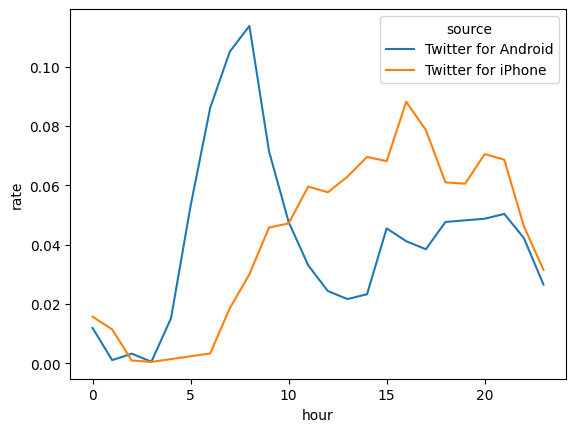

In [15]:
sns.lineplot(data=df_plot, x='hour', y='rate', hue='source')

plt.show()

In [16]:
# Top 10 commun words
df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
Name: count, dtype: int64

In [17]:
# Top 10 commun words
df['text'].apply(lambda x: remove_stopwords(x)).str.split(expand=True).stack().value_counts()[:10]

thank                     709
great                     610
-                         462
#trump2016                414
hillary                   352
&amp;                     316
new                       280
#makeamericagreatagain    260
people                    224
make                      218
Name: count, dtype: int64

In [18]:
df['text_clean'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_symbols(x))
df['text_clean'] = df['text_clean'].str.replace("-", "")
df['text_clean'] = df['text_clean'].str.replace("#", "")
df['text_clean'] = df['text_clean'].str.replace("@", "")
df['text_clean'] = df['text_clean'].str.replace("tco", "")
df['text_clean'] = df['text_clean'].str.replace("https://", "")

In [19]:
df['text_clean']

12072    would like wish everyone happy healthy new yea...
12073    believe state department new years eve release...
12074    thank illinois! lets forget get family amp; fr...
12075    happy birthday son donaldjtrumpjr! proud you! ...
12076    would feel sorry jebbush badly campaign fact t...
                               ...                        
18502    well year officially begun many stops planned ...
18503    happy new year maralago! thank great family su...
18504                     happynewyearamerica! /eeqb8pdrue
18505    happy new year amp; thank you! /yo1yi8qbzy /ux...
18506    foxnews live members family 11:50 pm ring new ...
Name: text_clean, Length: 3946, dtype: object

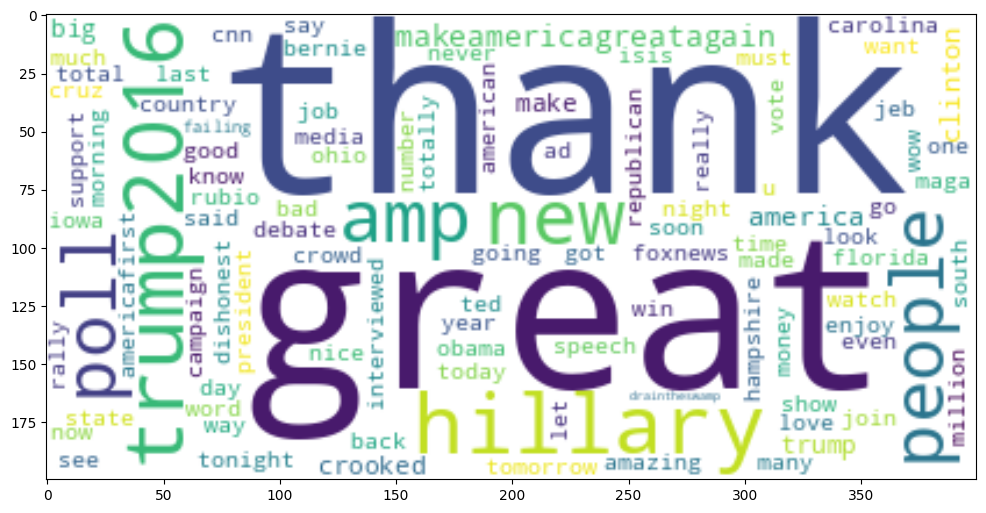

In [20]:
text = " ".join(i for i in df.text_clean)
word_cloud = WordCloud(max_words=100, background_color='White', collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

## Second Part

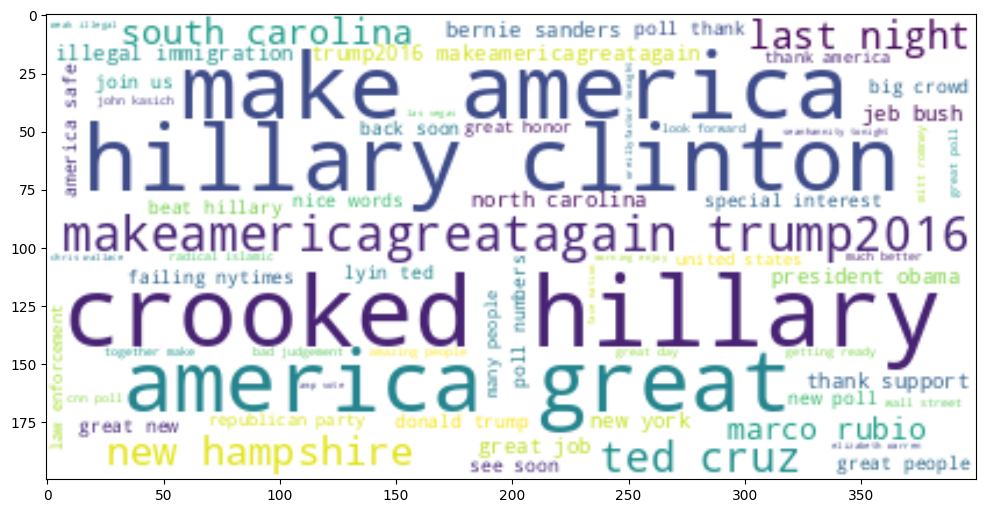

In [21]:
# Bigrama colection two tokens consecutives
word_cloud_2 = WordCloud(collocation_threshold=2, collocations=True, max_words=100, background_color='white').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.show()

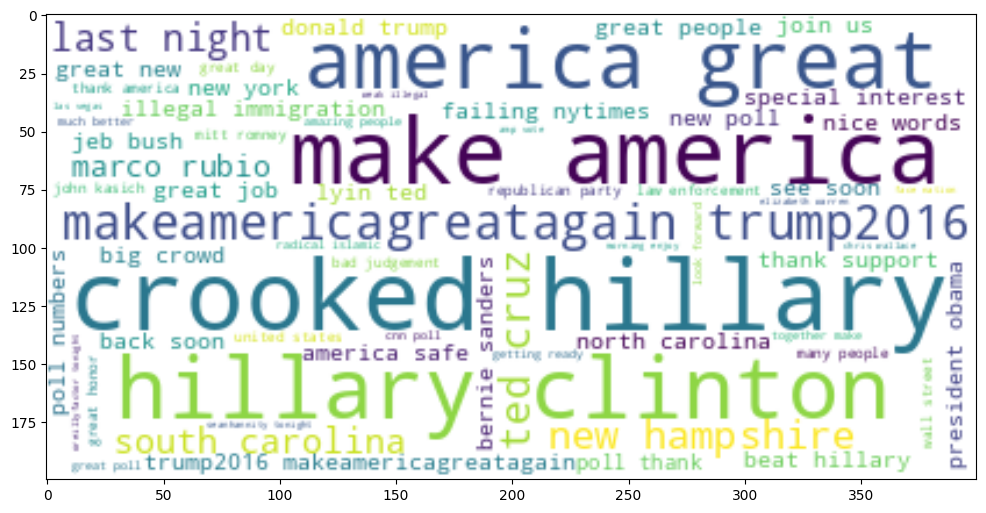

In [22]:
# Bigrama colection two tokens consecutives

word_cloud_3 = WordCloud(collocation_threshold=3, collocations=True, max_words=100, background_color='white').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(word_cloud_3, interpolation='bilinear')
plt.show()

In [23]:
# Determine sentiment depending on the device
df_word_split = (
    df
    .drop(['text', 'created_at', 'retweet_count', 'favorite_count'], axis=1)
    .assign(text=df['text_clean'].str.split())
).explode('text').drop('text_clean', axis=1).rename(columns={'text':'word'})
df_word_split

,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together!
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [24]:
df_word_split['word'].value_counts(normalize=True)

word
thank          0.016540
great          0.014580
trump2016      0.009658
hillary        0.009051
amp;           0.007372
                 ...   
mired          0.000023
department:    0.000023
/wwfdaectvu    0.000023
risk:          0.000023
pence:         0.000023
Name: proportion, Length: 9485, dtype: float64

In [25]:
(
    df_word_split
    .groupby(['source', 'word'], observed=True)
    .agg(count=('word', 'count'))
    .reset_index()
    .merge(nrc[['word', 'sentiment']], on='word', how='inner')
    .drop(['word', 'count'], axis=1)['sentiment'].value_counts()
)

sentiment
positive        710
negative        656
trust           441
fear            338
sadness         320
anger           316
anticipation    281
joy             229
disgust         204
surprise        163
Name: count, dtype: int64

In [30]:
# Per device
df_sent = (
    df_word_split
    .merge(nrc[['word', 'sentiment']], on='word', how='inner')
    .groupby(['source', 'sentiment'], observed=False)
    .agg(count=('sentiment', 'count'))
    .reset_index()
    .pivot_table(index=['sentiment'], columns=['source'], values='count', observed=False)
    .reset_index()
    .rename(columns={'Twitter for Android': 'android', 'Twitter for iPhone': 'iphone'})
)
df_sent

source,sentiment,android,iphone
0,anger,871.0,467.0
1,anticipation,844.0,593.0
2,disgust,562.0,282.0
3,fear,755.0,441.0
4,joy,619.0,456.0
5,negative,1503.0,843.0
6,positive,1763.0,1388.0
7,sadness,826.0,464.0
8,surprise,525.0,352.0
9,trust,1228.0,904.0


In [32]:
# Conteo de chances
df_odd_ratio = (
    df_sent
    .assign(odd_ratio=(df_sent['android']/(df_sent['android'].sum()-df_sent['android']))/(df_sent['iphone']/(df_sent['iphone'].sum()-df_sent['iphone'])))
)
df_odd_ratio

source,sentiment,android,iphone,odd_ratio
0,anger,871.0,467.0,1.237559
1,anticipation,844.0,593.0,0.920718
2,disgust,562.0,282.0,1.317898
3,fear,755.0,441.0,1.126003
4,joy,619.0,456.0,0.876834
5,negative,1503.0,843.0,1.192702
6,positive,1763.0,1388.0,0.788746
7,sadness,826.0,464.0,1.175694
8,surprise,525.0,352.0,0.970599
9,trust,1228.0,904.0,0.868474


### **Ratio**
odd_ratio = P(event occurring divided by the probability of the event not occurring)
- odd = P(E)/P(~E) = p/(1-p)
#### Example:
ratio_anger = 467/871 = 1.24

In [33]:
df_odd_ratio['log_or'] = np.log(df_odd_ratio['odd_ratio'])
df_odd_ratio

source,sentiment,android,iphone,odd_ratio,log_or
0,anger,871.0,467.0,1.237559,0.213141
1,anticipation,844.0,593.0,0.920718,-0.082602
2,disgust,562.0,282.0,1.317898,0.276038
3,fear,755.0,441.0,1.126003,0.118674
4,joy,619.0,456.0,0.876834,-0.131438
5,negative,1503.0,843.0,1.192702,0.176221
6,positive,1763.0,1388.0,0.788746,-0.237311
7,sadness,826.0,464.0,1.175694,0.161859
8,surprise,525.0,352.0,0.970599,-0.029842
9,trust,1228.0,904.0,0.868474,-0.141018


Chances de que ocurra 'anger' en android es de 1.24

Cuanto mas cercano a 0 es el log_odd es menos probable, mas despegado a 0 es mejor

In [34]:
# Std error (se) the variations when binary values
df_odd_ratio['se'] = np.sqrt(1/df_odd_ratio['android']+1/(df_odd_ratio['android'].sum()-df_odd_ratio['android'])+1/df_odd_ratio['iphone']+1/(df_odd_ratio['iphone'].sum()+df_odd_ratio['iphone']))
df_odd_ratio

source,sentiment,android,iphone,odd_ratio,log_or,se
0,anger,871.0,467.0,1.237559,0.213141,0.059629
1,anticipation,844.0,593.0,0.920718,-0.082602,0.055984
2,disgust,562.0,282.0,1.317898,0.276038,0.074779
3,fear,755.0,441.0,1.126003,0.118674,0.062107
4,joy,619.0,456.0,0.876834,-0.131438,0.063809
5,negative,1503.0,843.0,1.192702,0.176221,0.046031
6,positive,1763.0,1388.0,0.788746,-0.237311,0.039357
7,sadness,826.0,464.0,1.175694,0.161859,0.060262
8,surprise,525.0,352.0,0.970599,-0.029842,0.070781
9,trust,1228.0,904.0,0.868474,-0.141018,0.046717


In [38]:
# Confidence intervals 
df_odd_ratio['conf_low'] = df_odd_ratio['log_or'] - norm.ppf(0.975) * df_odd_ratio['se']
df_odd_ratio['conf_high'] = df_odd_ratio['log_or'] + norm.ppf(0.975) * df_odd_ratio['se']
df_odd_ratio.sort_values(by='log_or', ascending=True)

source,sentiment,android,iphone,odd_ratio,log_or,se,conf_low,conf_high
6,positive,1763.0,1388.0,0.788746,-0.237311,0.039357,-0.314449,-0.160174
9,trust,1228.0,904.0,0.868474,-0.141018,0.046717,-0.232581,-0.049455
4,joy,619.0,456.0,0.876834,-0.131438,0.063809,-0.256501,-0.006374
1,anticipation,844.0,593.0,0.920718,-0.082602,0.055984,-0.192328,0.027124
8,surprise,525.0,352.0,0.970599,-0.029842,0.070781,-0.168571,0.108887
3,fear,755.0,441.0,1.126003,0.118674,0.062107,-0.003053,0.240402
7,sadness,826.0,464.0,1.175694,0.161859,0.060262,0.043748,0.279969
5,negative,1503.0,843.0,1.192702,0.176221,0.046031,0.086001,0.266440
0,anger,871.0,467.0,1.237559,0.213141,0.059629,0.096271,0.330011
2,disgust,562.0,282.0,1.317898,0.276038,0.074779,0.129474,0.422602


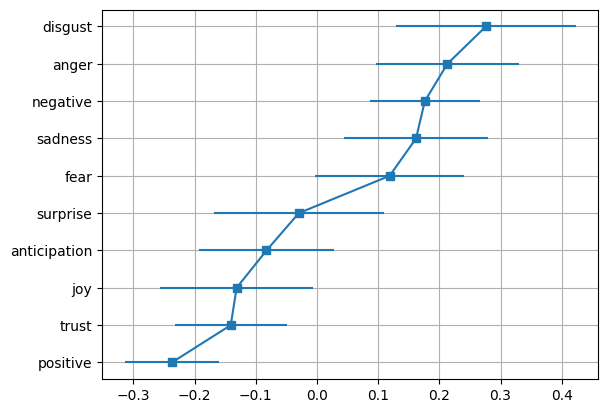

In [46]:
df_odd_ratio = df_odd_ratio.sort_values(by='log_or', ascending=True)
plt.errorbar(df_odd_ratio['log_or'], df_odd_ratio['sentiment'], xerr=((df_odd_ratio['log_or']-df_odd_ratio['conf_low']), (df_odd_ratio['conf_high']-df_odd_ratio['log_or'])), marker='s')
plt.grid(True)
plt.show()

In [61]:
# Bigrams
df_bigrams = df.copy()
df_bigrams['bigrams_list'] = df_bigrams['text_clean'].apply(lambda row: list(nltk.ngrams(row.split(' '), 2)))
df_bigrams

,source,text,created_at,retweet_count,favorite_count,text_clean,bigrams_list
12072,Twitter for Android,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 18:21:49+00:00,6776,16495,would like wish everyone happy healthy new yea...,"[(would, like), (like, wish), (wish, everyone)..."
12073,Twitter for Android,"Do you believe that The State Department, on N...",2015-12-31 18:11:35+00:00,2755,6824,believe state department new years eve release...,"[(believe, state), (state, department), (depar..."
12074,Twitter for iPhone,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 13:51:12+00:00,2468,6047,thank illinois! lets forget get family amp; fr...,"[(thank, illinois!), (illinois!, lets), (lets,..."
12075,Twitter for iPhone,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Ver...",2015-12-31 11:52:38+00:00,2080,8416,happy birthday son donaldjtrumpjr! proud you! ...,"[(happy, birthday), (birthday, son), (son, don..."
12076,Twitter for Android,I would feel sorry for @JebBush and how badly ...,2015-12-31 10:07:18+00:00,1875,5780,would feel sorry jebbush badly campaign fact t...,"[(would, feel), (feel, sorry), (sorry, jebbush..."
...,...,...,...,...,...,...,...
18502,Twitter for Android,"Well, the year has officially begun. I have ma...",2016-01-01 18:00:09+00:00,2642,8495,well year officially begun many stops planned ...,"[(well, year), (year, officially), (officially..."
18503,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,2016-01-01 01:07:28+00:00,1948,8258,happy new year maralago! thank great family su...,"[(happy, new), (new, year), (year, maralago!),..."
18504,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,2016-01-01 00:18:23+00:00,3434,9143,happynewyearamerica! /eeqb8pdrue,"[(happynewyearamerica!, /eeqb8pdrue)]"
18505,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,2015-12-31 22:25:27+00:00,3460,8581,happy new year amp; thank you! /yo1yi8qbzy /ux...,"[(happy, new), (new, year), (year, amp;), (amp..."


In [62]:
df_bigrams = df_bigrams["bigrams_list"].explode().to_frame().copy()
df_bigrams

,bigrams_list
12072,"(would, like)"
12072,"(like, wish)"
12072,"(wish, everyone)"
12072,"(everyone, happy)"
12072,"(happy, healthy)"
...,...
18506,"(year, together!)"
18506,"(together!, make)"
18506,"(make, america)"
18506,"(america, great)"


In [63]:
df_bigrams.value_counts()

bigrams_list              
(crooked, hillary)            176
(make, america)               173
(hillary, clinton)            148
(great, again!)               143
(america, great)              143
                             ... 
(gatewaypundit, reporting)      1
(gates, look)                   1
(gates, knows)                  1
(gatekeeper, state)             1
(gave, lives)                   1
Name: count, Length: 30885, dtype: int64

In [67]:
df_bigrams_cut = (
    df_bigrams
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'index':'bigrams', 'bigrams_list':'bigrams'})
    .copy()
    )
df_bigrams_cut

,bigrams,count
0,"(crooked, hillary)",176
1,"(make, america)",173
2,"(hillary, clinton)",148
3,"(great, again!)",143
4,"(america, great)",143
...,...,...
30880,"(gatewaypundit, reporting)",1
30881,"(gates, look)",1
30882,"(gates, knows)",1
30883,"(gatekeeper, state)",1


In [68]:
df_bigrams_reduced = df_bigrams_cut[df_bigrams_cut['count']>30]
d = df_bigrams_reduced.set_index('bigrams').T.to_dict('records')
d

[{('crooked', 'hillary'): 176,
  ('make', 'america'): 173,
  ('hillary', 'clinton'): 148,
  ('great', 'again!'): 143,
  ('america', 'great'): 143,
  ('thank', 'you!'): 140,
  ('makeamericagreatagain', 'trump2016'): 123,
  ('ted', 'cruz'): 88,
  ('thank', 'you'): 67,
  ('new', 'hampshire'): 57,
  ('last', 'night'): 55,
  ('marco', 'rubio'): 43,
  ('trump2016', 'makeamericagreatagain'): 41,
  ('south', 'carolina'): 38,
  ('bernie', 'sanders'): 37,
  ('illegal', 'immigration'): 34,
  ('jeb', 'bush'): 32,
  ('failing', 'nytimes'): 32,
  ('president', 'obama'): 31,
  ('new', 'york'): 31}]

In [70]:
weights = [v for k, v in d[0].items()]
widths = [((v - min(weights))* 9 / (max(weights) - min(weights))) + 1 for v in weights]

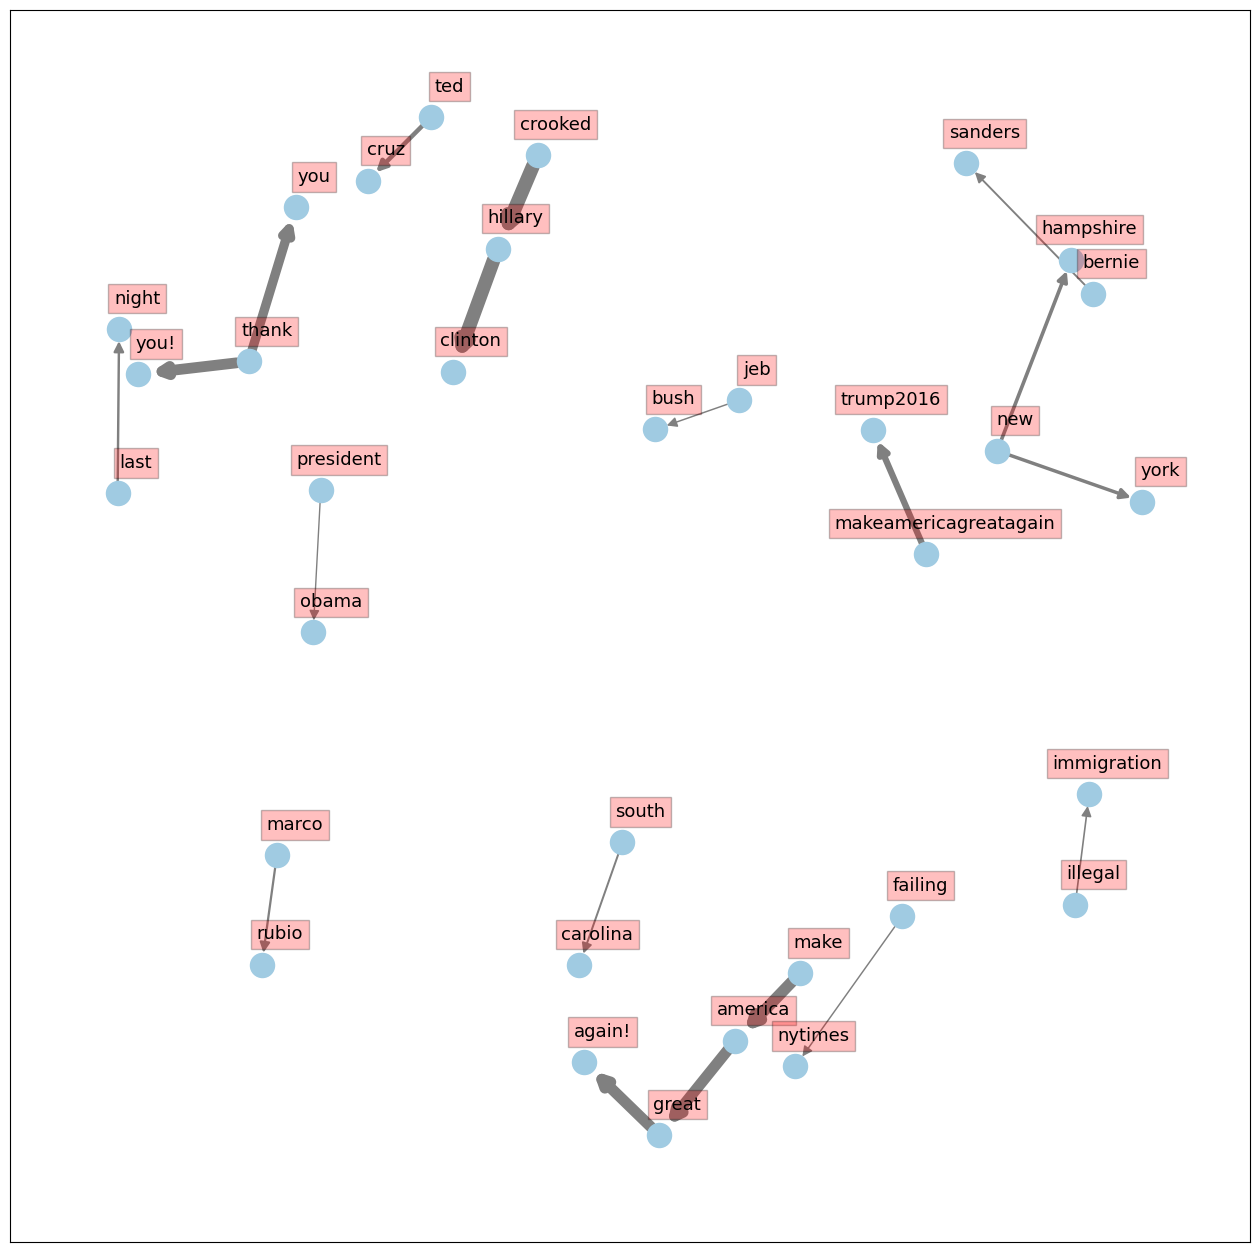

In [ ]:

G = nx.Graph()
for k,v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*1.25))
fig, ax = plt.subplots(figsize=(16,16))
pos = nx.spring_layout(G, k=2)
options = {
    'arrowstyle': '-|>',
    'arrowsize': 15,
}
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=widths,
                 edge_color='grey',
                 node_color="#A0CBE2",
                 with_labels = False,
                 arrows=True,
                 ax=ax,
**options)
for key,value in pos.items():
    x, y = value[0] + .035, value[1] + .045
    ax.text(x,y, s=key, bbox=dict(facecolor="red", alpha=0.25), horizontalalignment="center", fontsize=13)

plt.show()